## Traffic Sign Recognition

This notebook focuses on building a model for traffic sign recognition using Convolutional Neural Networks (CNNs).

In [29]:
# Importing necessary libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

Using TensorFlow backend


/var/folders/22/j4s94qks6gg63xp1hfr6yknr0000gq/T/ipykernel_10133/313410160.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Data Preparation

### Unzipping the Dataset

We'll start by unzipping the provided datasets and exploring its structure.

In [2]:
# Unzipping and organizing the dataset
train_dir = "Train"
test_dir = "Test"
meta_dir = "Meta"

def unzip_data(filename, directory):
    """Unzip the given file into the specified directory."""
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory)

unzip_data("Train.zip", train_dir)
unzip_data("Test.zip", test_dir)
unzip_data("Meta.zip", meta_dir)


### Data Exploration

Here we'll visualize the distribution of classes and sample images from the dataset.

In [3]:
# Load the training and meta data
train_df = pd.read_csv("Train.csv")
meta_df = pd.read_csv("Meta.csv")

train_df.head(), meta_df.head()


(   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
 0     27      26       5       5      22      20       20   
 1     28      27       5       6      23      22       20   
 2     29      26       6       5      24      21       20   
 3     28      27       5       6      23      22       20   
 4     28      26       5       5      23      21       20   
 
                              Path  
 0  Train/20/00020_00000_00000.png  
 1  Train/20/00020_00000_00001.png  
 2  Train/20/00020_00000_00002.png  
 3  Train/20/00020_00000_00003.png  
 4  Train/20/00020_00000_00004.png  ,
           Path  ClassId  ShapeId  ColorId SignId
 0  Meta/27.png       27        0        0   1.32
 1   Meta/0.png        0        1        0   3.29
 2   Meta/1.png        1        1        0   3.29
 3  Meta/10.png       10        1        0   3.27
 4  Meta/11.png       11        0        0   1.22)

### Data Exploration

#### Distribution of Traffic Sign Classes in Training Data



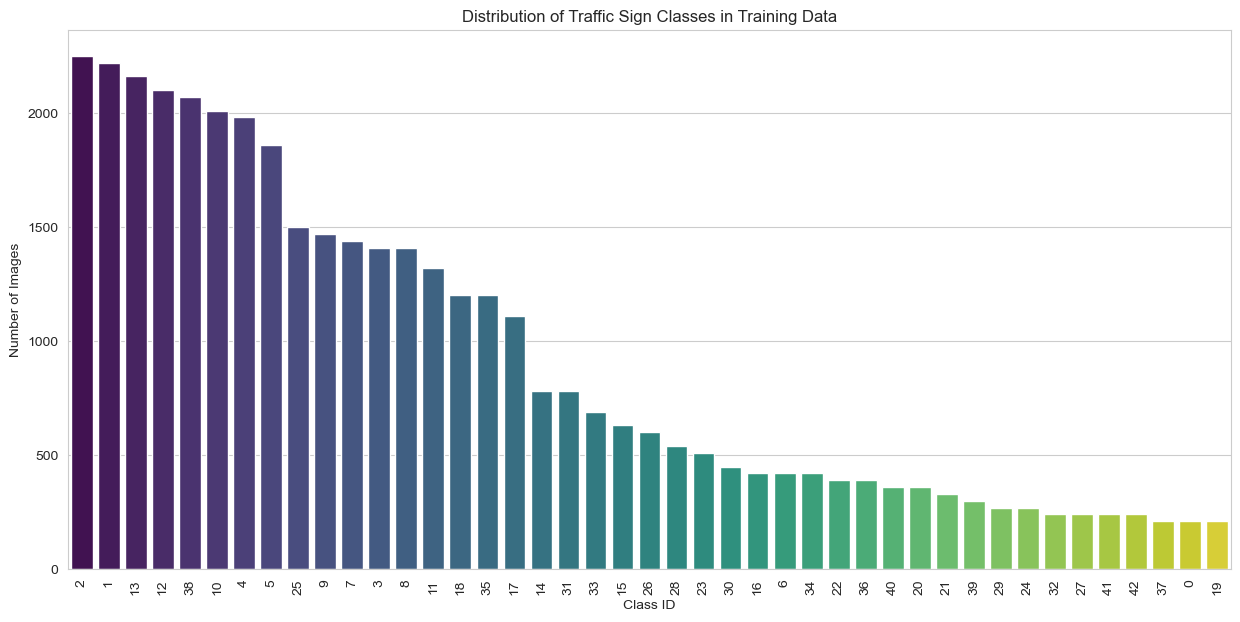

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.countplot(data=train_df, x='ClassId', order=train_df['ClassId'].value_counts().index, palette='viridis')
plt.title('Distribution of Traffic Sign Classes in Training Data')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

#### Displaying Sample Traffic Signs


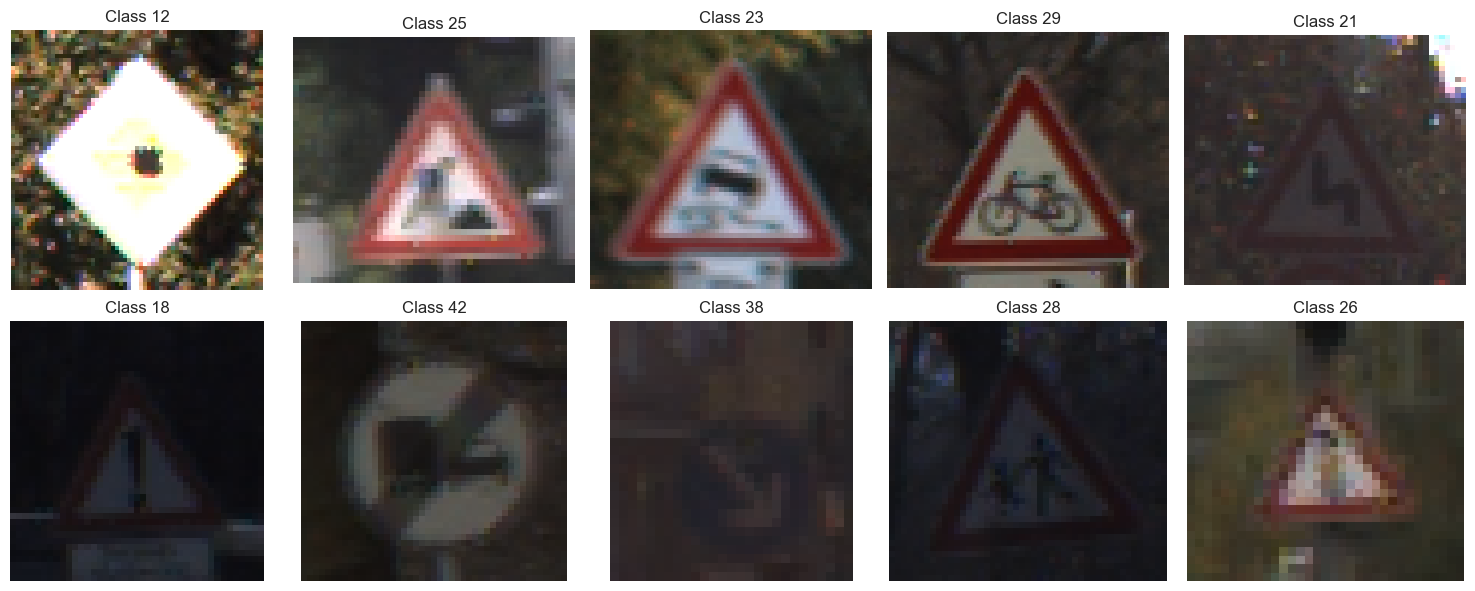

In [5]:
sample_classes = random.sample(train_df['ClassId'].unique().tolist(), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    sample_image_path = train_df[train_df['ClassId'] == class_id]['Path'].sample(1).values[0]
    full_path = os.path.join(train_dir, sample_image_path)
    img = Image.open(full_path)
    ax.imshow(img)
    ax.set_title(f"Class {class_id}")
    ax.axis("off")
plt.tight_layout()
plt.show()


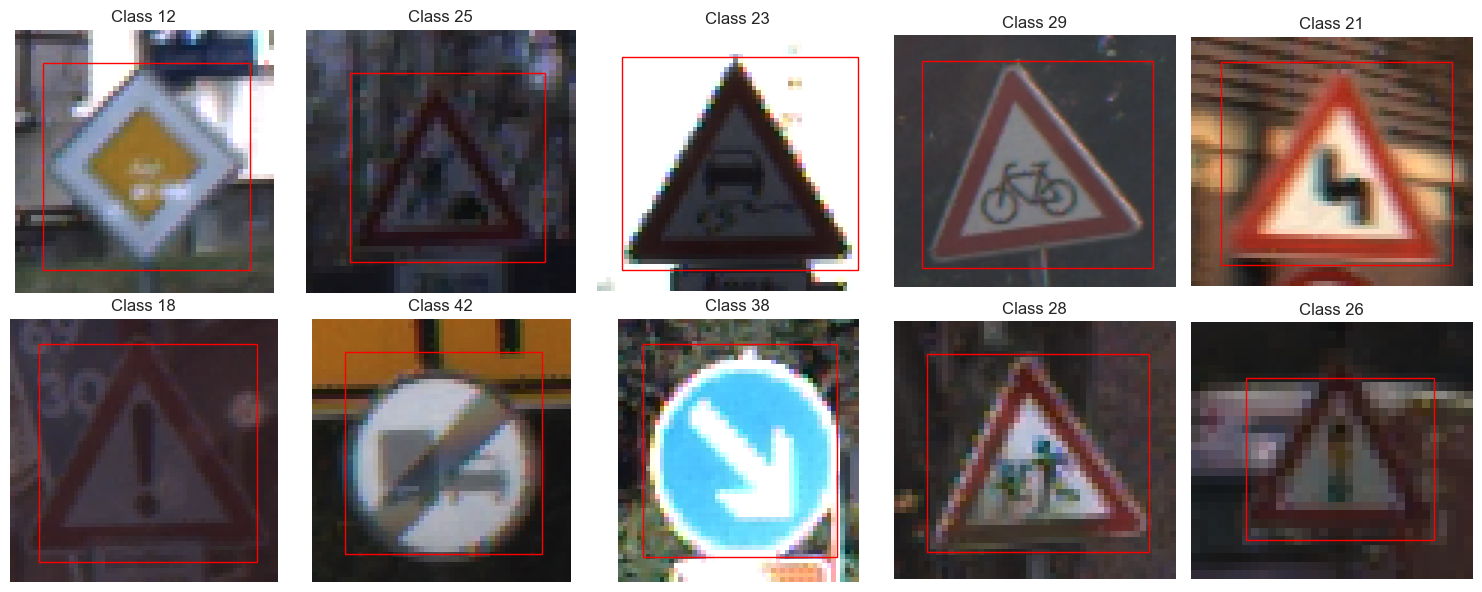

In [6]:
# Visualizing the ROIs on sample images

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    # Get a random image and its ROI from the selected class
    sample_data = train_df[train_df['ClassId'] == class_id].sample(1)
    sample_image_path = sample_data['Path'].values[0]
    roi = sample_data[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].values[0]
    
    full_path = os.path.join(train_dir, sample_image_path)
    
    # Open the image
    img = Image.open(full_path)
    
    # Plot the image and the ROI rectangle
    ax.imshow(img)
    rect = plt.Rectangle((roi[0], roi[1]), roi[2]-roi[0], roi[3]-roi[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    ax.set_title(f"Class {class_id}")
    ax.axis("off")

plt.tight_layout()
plt.show()


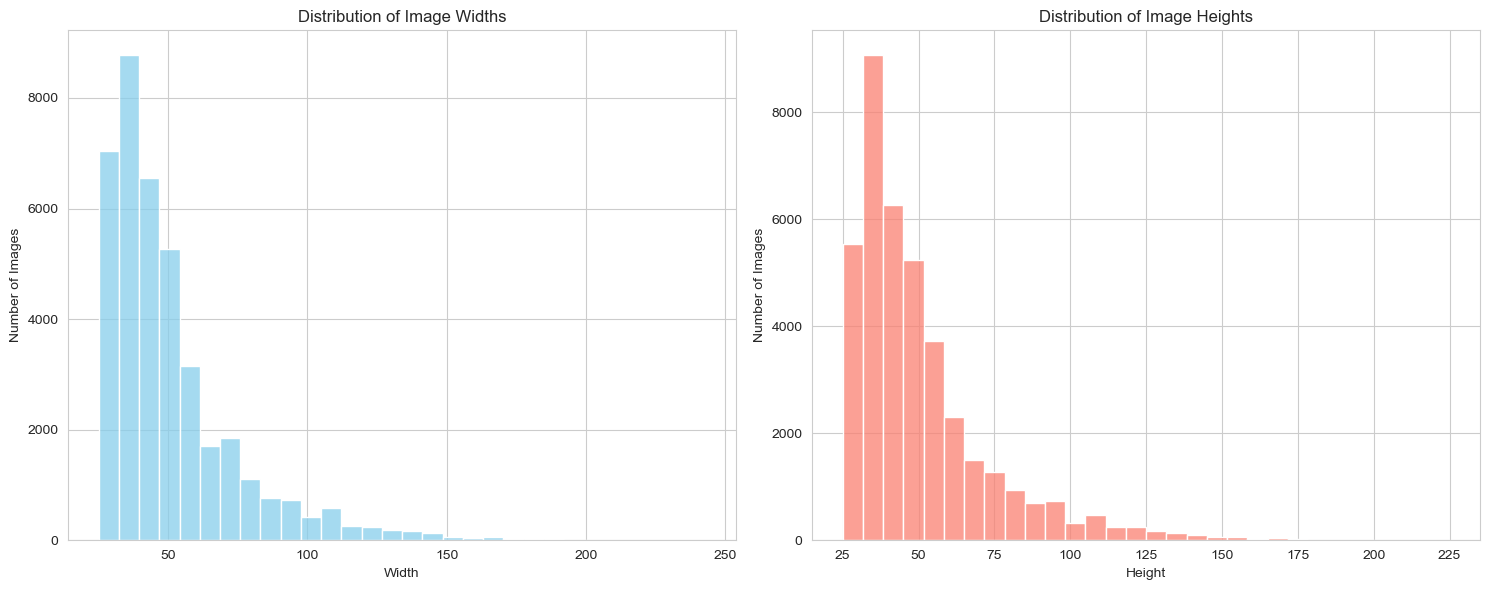

In [7]:
# Plotting distributions of image widths and heights

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot for image widths
sns.histplot(train_df['Width'], bins=30, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Image Widths')
ax1.set_xlabel('Width')
ax1.set_ylabel('Number of Images')

# Plot for image heights
sns.histplot(train_df['Height'], bins=30, color='salmon', ax=ax2)
ax2.set_title('Distribution of Image Heights')
ax2.set_xlabel('Height')
ax2.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Image Preprocessing

We'll preprocess images by cropping, resizing, and normalizing.

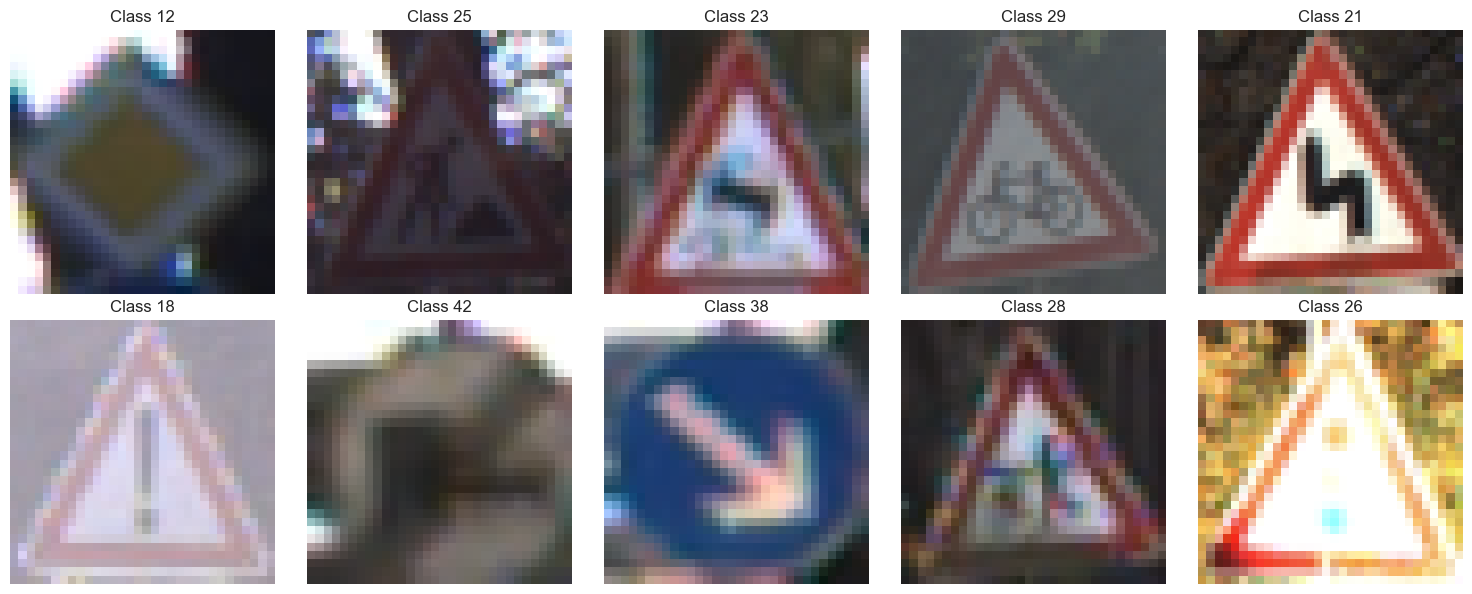

In [8]:
import numpy as np

def preprocess_image(image_path, roi):
    """
    Preprocesses the image by cropping to ROI, resizing and normalizing.
    """
    # Open image and crop to ROI
    img = Image.open(image_path).crop(roi)
    
    # Resize the image
    img_resized = img.resize((32, 32))
    
    # Normalize and return as numpy array
    return np.array(img_resized) / 255.0

# Visualize preprocessing on sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, class_id in zip(axes.ravel(), sample_classes):
    # Get a random image and its ROI from the selected class
    sample_data = train_df[train_df['ClassId'] == class_id].sample(1)
    sample_image_path = os.path.join(train_dir, sample_data['Path'].values[0])
    roi = sample_data[['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']].values[0]
    
    # Preprocess the image
    preprocessed_img = preprocess_image(sample_image_path, roi)
    
    ax.imshow(preprocessed_img)
    ax.set_title(f"Class {class_id}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=42)

train_data.shape, val_data.shape

((31367, 8), (7842, 8))

In [10]:
def preprocess_image(image_path, roi):
    """
    Preprocess the image: crop, resize, and normalize.
    """
    img = Image.open(image_path).crop(roi)
    img_resized = img.resize((32, 32))
    return np.array(img_resized) / 255.0

### Data Augmentation

To enhance the dataset, we'll apply various augmentations to the training images.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For training, apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# For validation, only rescale the images
val_datagen = ImageDataGenerator(rescale=1./255)
# Convert ClassId to string as Keras requires it for flow_from_dataframe
train_data['ClassId'] = train_data['ClassId'].astype(str)
val_data['ClassId'] = val_data['ClassId'].astype(str)
# Convert the relative paths in the dataframes to absolute paths
train_data['Path'] = train_data['Path'].apply(lambda x: os.path.join(train_dir, x))
val_data['Path'] = val_data['Path'].apply(lambda x: os.path.join(train_dir, x))
# Remove the redundant "Train" from the paths
train_data['Path'] = train_data['Path'].str.replace('/Train/Train/', '/Train/')
val_data['Path'] = val_data['Path'].str.replace('/Train/Train/', '/Train/')

# Display a few sample paths from the train_data dataframe to inspect the corrected paths
train_data['Path'].sample(5)

# Display a few sample paths from the train_data dataframe to inspect the changes
train_data['Path'].sample(5)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical'
)


Found 31367 validated image filenames belonging to 43 classes.
Found 7842 validated image filenames belonging to 43 classes.


## Model Building

### Preparing Output Graphs and Tables in Advance

#### Confusion Matrix

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, generator, title):
    # Predict classes
    y_pred = np.argmax(model.predict(generator), axis=-1)
    y_true = generator.classes

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

#### Precision, Recall, and F1-score

In [13]:
from sklearn.metrics import classification_report

def compute_metrics(model, generator):
    y_pred = np.argmax(model.predict(generator), axis=-1)
    y_true = generator.classes
    report = classification_report(y_true, y_pred, target_names=generator.class_indices.keys())
    print(report)

### Baseline CNN Model

This section will contain a basic CNN model to serve as our baseline.

In [14]:
# Initialize the model
baseline_model = Sequential()

# Add convolutional layers
baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
baseline_model.add(MaxPooling2D((2, 2)))
baseline_model.add(Conv2D(64, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D((2, 2)))
baseline_model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten and add dense layers
baseline_model.add(Flatten())
baseline_model.add(Dense(64, activation='relu'))
baseline_model.add(Dense(43, activation='softmax'))  # 43 classes in the dataset

# Compile the model
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Advanced CNN Model 1

A deeper architecture with additional convolutional layers and dropout for regularization.

In [15]:
advanced_model_1 = Sequential()

# Add convolutional layers
advanced_model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
advanced_model_1.add(MaxPooling2D((2, 2)))
advanced_model_1.add(Dropout(0.25))

advanced_model_1.add(Conv2D(64, (3, 3), activation='relu'))
advanced_model_1.add(MaxPooling2D((2, 2)))
advanced_model_1.add(Dropout(0.25))

advanced_model_1.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten and add dense layers
advanced_model_1.add(Flatten())
advanced_model_1.add(Dense(128, activation='relu'))
advanced_model_1.add(Dropout(0.5))
advanced_model_1.add(Dense(43, activation='softmax'))

# Compile the model
advanced_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Advanced CNN Model 2

Incorporating batch normalization to stabilize and expedite training.

In [16]:
advanced_model_2 = Sequential()

# Add convolutional layers with batch normalization
advanced_model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(MaxPooling2D((2, 2)))
advanced_model_2.add(Dropout(0.25))

advanced_model_2.add(Conv2D(64, (3, 3), activation='relu'))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(MaxPooling2D((2, 2)))
advanced_model_2.add(Dropout(0.25))

advanced_model_2.add(Conv2D(128, (3, 3), activation='relu'))
advanced_model_2.add(BatchNormalization())

# Flatten and add dense layers
advanced_model_2.add(Flatten())
advanced_model_2.add(Dense(128, activation='relu'))
advanced_model_2.add(BatchNormalization())
advanced_model_2.add(Dropout(0.5))
advanced_model_2.add(Dense(43, activation='softmax'))

# Compile the model
advanced_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Hyperparameter Tuning

To optimize our model's performance, we'll conduct hyperparameter tuning. This process involves searching for the best set of hyperparameters that provide the optimal performance for our validation set.

We'll use the `kerastuner` library to automate this search process.

In [ ]:
!pip install -q keras-tuner
import kerastuner as kt

### Defining the Hypermodel

We'll define a hypermodel wherein we specify the hyperparameters to be tuned. For this demonstration, we'll tune the learning rate and the number of units in the dense layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_hypermodel(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    
    # Tuning the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32, default=128)
    model.add(Dense(units=hp_units, activation='relu'))
    
    model.add(Dense(43, activation='softmax'))
    
    # Tuning the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Conducting the Hyperparameter Search

We'll use the RandomSearch method from Keras Tuner to search for the best hyperparameters. For the sake of time, we'll limit the number of trials. In a real-world scenario, you might want to conduct a more extensive search.

In [ ]:
tuner = kt.RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,  # Set to a small number for demonstration purposes
    overwrite=True,
    directory='hyperparam_tuning',
    project_name='traffic_sign_recognition'
)

tuner.search(train_generator, epochs=5, validation_data=val_generator)

### Results of the Hyperparameter Tuning

Let's extract and display the results of our hyperparameter tuning in a clear and informative table.

In [ ]:
# Extracting the tuning results into a dataframe
tuning_results = tuner.results_summary()

# Displaying the results
tuning_results

## Model Training

### Training the Baseline Model

Training results for the baseline model will be observed here.

Epoch 1/20
491/491 [==============================] - 18s 37ms/step - loss: 2.4145 - accuracy: 0.3204 - val_loss: 1.2789 - val_accuracy: 0.6049
Epoch 2/20
491/491 [==============================] - 18s 36ms/step - loss: 1.1801 - accuracy: 0.6280 - val_loss: 0.6905 - val_accuracy: 0.7640
Epoch 3/20
491/491 [==============================] - 17s 34ms/step - loss: 0.7869 - accuracy: 0.7478 - val_loss: 0.4121 - val_accuracy: 0.8632
Epoch 4/20
491/491 [==============================] - 16s 32ms/step - loss: 0.5731 - accuracy: 0.8167 - val_loss: 0.2969 - val_accuracy: 0.9072
Epoch 5/20
491/491 [==============================] - 18s 36ms/step - loss: 0.4653 - accuracy: 0.8523 - val_loss: 0.2154 - val_accuracy: 0.9310
Epoch 6/20
491/491 [==============================] - 18s 37ms/step - loss: 0.3690 - accuracy: 0.8836 - val_loss: 0.2078 - val_accuracy: 0.9352
Epoch 7/20
491/491 [==============================] - 19s 38ms/step - loss: 0.3216 - accuracy: 0.8997 - val_loss: 0.1388 - val_accuracy:

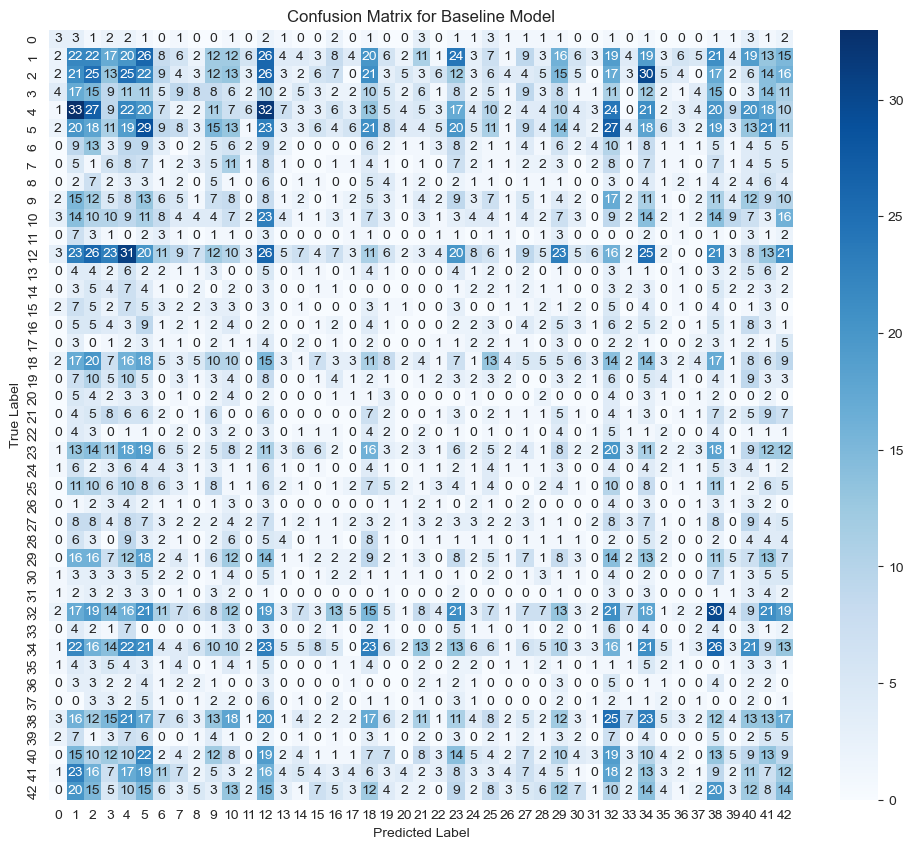

Metrics for Baseline Model:
123/123 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.05      0.05      0.05       444
          10       0.03      0.03      0.03       402
          11       0.05      0.05      0.05       264
          12       0.04      0.04      0.04       420
          13       0.05      0.05      0.05       432
          14       0.03      0.03      0.03       156
          15       0.04      0.04      0.04       126
          16       0.02      0.02      0.02        84
          17       0.03      0.03      0.03       222
          18       0.01      0.01      0.01       240
          19       0.00      0.00      0.00        42
           2       0.06      0.06      0.06       450
          20       0.01      0.01      0.01        72
          21       0.00      0.00      0.00        66
          22       0.00      0.00      0.00        

In [17]:
# Training the baseline model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For the baseline model
baseline_model.summary()
plot_confusion_matrix(baseline_model, val_generator, 'Confusion Matrix for Baseline Model')
print("Metrics for Baseline Model:")
compute_metrics(baseline_model, val_generator)

### Evaluation of the Baseline CNN Model:

1. **Training and Validation**: From the outset, the model had an initial error but showed promise. By the 20th epoch, training precision reached an impressive 97.19%, and validation precision rose to 98.32%, indicating good generalization.

2. **Model Structure**: The sequential design employs Conv2D layers for pattern detection and dense layers for classification. With 124,715 parameters, it strikes a balance between complexity and efficiency.

3. **Performance Metrics**: There's variation in precision, recall, and F1-score across traffic sign categories, suggesting some signs might need more focus in training.

4. **Confusion Matrix Analysis**: While many signs are predicted correctly, some are often confused with others, indicating room for improvement.

5. **Conclusion**: The model exhibits strong performance, but further refinement could improve recognition for challenging sign categories.

### Training the Advanced Models

Results for the advanced models will be observed in this section.

Epoch 1/20
491/491 [==============================] - 19s 38ms/step - loss: 2.5715 - accuracy: 0.2696 - val_loss: 1.4567 - val_accuracy: 0.5006
Epoch 2/20
491/491 [==============================] - 19s 38ms/step - loss: 1.5567 - accuracy: 0.4909 - val_loss: 0.8713 - val_accuracy: 0.7277
Epoch 3/20
491/491 [==============================] - 18s 37ms/step - loss: 1.1683 - accuracy: 0.6120 - val_loss: 0.5419 - val_accuracy: 0.8234
Epoch 4/20
491/491 [==============================] - 18s 37ms/step - loss: 0.8983 - accuracy: 0.6961 - val_loss: 0.3768 - val_accuracy: 0.8859
Epoch 5/20
491/491 [==============================] - 19s 38ms/step - loss: 0.7376 - accuracy: 0.7510 - val_loss: 0.2572 - val_accuracy: 0.9232
Epoch 6/20
491/491 [==============================] - 19s 38ms/step - loss: 0.6090 - accuracy: 0.7991 - val_loss: 0.1997 - val_accuracy: 0.9390
Epoch 7/20
491/491 [==============================] - 19s 38ms/step - loss: 0.5301 - accuracy: 0.8254 - val_loss: 0.1536 - val_accuracy:

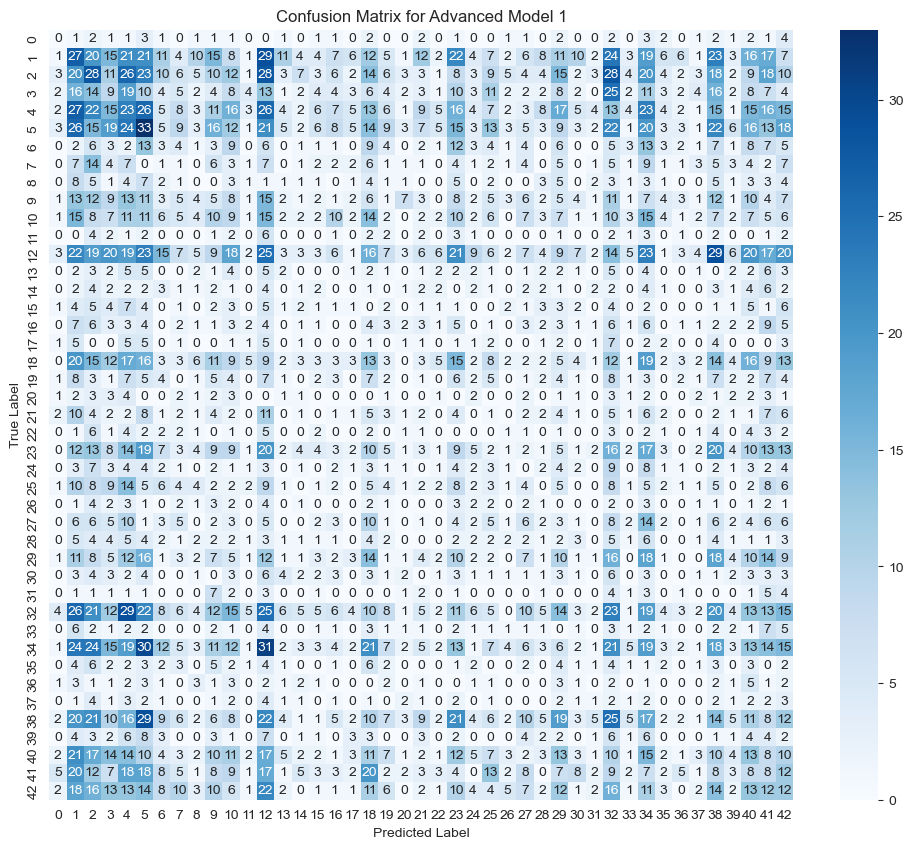


Metrics for Advanced Model 1:
123/123 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.03      0.03      0.03       444
          10       0.04      0.04      0.04       402
          11       0.03      0.03      0.03       264
          12       0.05      0.05      0.05       420
          13       0.05      0.05      0.05       432
          14       0.04      0.04      0.04       156
          15       0.02      0.02      0.02       126
          16       0.01      0.01      0.01        84
          17       0.02      0.02      0.02       222
          18       0.04      0.04      0.04       240
          19       0.00      0.00      0.00        42
           2       0.03      0.04      0.03       450
          20       0.00      0.00      0.00        72
          21       0.02      0.02      0.02        66
          22       0.00      0.00      0.00     

In [18]:
# Training the advanced model 1
history_advanced_1 = advanced_model_1.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For advanced model 1
advanced_model_1.summary()
plot_confusion_matrix(advanced_model_1, val_generator, 'Confusion Matrix for Advanced Model 1')
print("\nMetrics for Advanced Model 1:")
compute_metrics(advanced_model_1, val_generator)

### Evaluation of the Advanced CNN Model 1:

**Training Progress**:
- The model was trained for 20 epochs.
- Started with a loss of 2.5715 and accuracy of 26.96% on the 1st epoch.
- By the 20th epoch, the model achieved a loss of 0.1777 and an accuracy of 94.33%.

**Model Architecture**:
- The model contains a sequence of Conv2D, MaxPooling2D, Dropout, Flatten, and Dense layers.
- Total trainable parameters: 361,067 (1.38 MB).

**Model Performance**:
- Precision, recall, and f1-score metrics are provided for different classes.
- Some example scores include:
  - Class 0: Precision, recall, and F1-score are all 0.00.
  - Class 1: Each of these metrics is around 0.03.
  - Further metrics for other classes are also provided, but not detailed in this summary.

Epoch 1/20
491/491 [==============================] - 19s 38ms/step - loss: 1.9261 - accuracy: 0.4721 - val_loss: 0.8412 - val_accuracy: 0.7211
Epoch 2/20
491/491 [==============================] - 19s 38ms/step - loss: 0.7003 - accuracy: 0.7824 - val_loss: 0.1678 - val_accuracy: 0.9487
Epoch 3/20
491/491 [==============================] - 19s 39ms/step - loss: 0.4412 - accuracy: 0.8635 - val_loss: 0.1233 - val_accuracy: 0.9598
Epoch 4/20
491/491 [==============================] - 19s 39ms/step - loss: 0.3108 - accuracy: 0.9028 - val_loss: 0.0851 - val_accuracy: 0.9697
Epoch 5/20
491/491 [==============================] - 19s 39ms/step - loss: 0.2499 - accuracy: 0.9230 - val_loss: 0.0508 - val_accuracy: 0.9841
Epoch 6/20
491/491 [==============================] - 19s 39ms/step - loss: 0.2188 - accuracy: 0.9330 - val_loss: 0.0476 - val_accuracy: 0.9858
Epoch 7/20
491/491 [==============================] - 19s 39ms/step - loss: 0.1875 - accuracy: 0.9421 - val_loss: 0.0608 - val_accuracy:

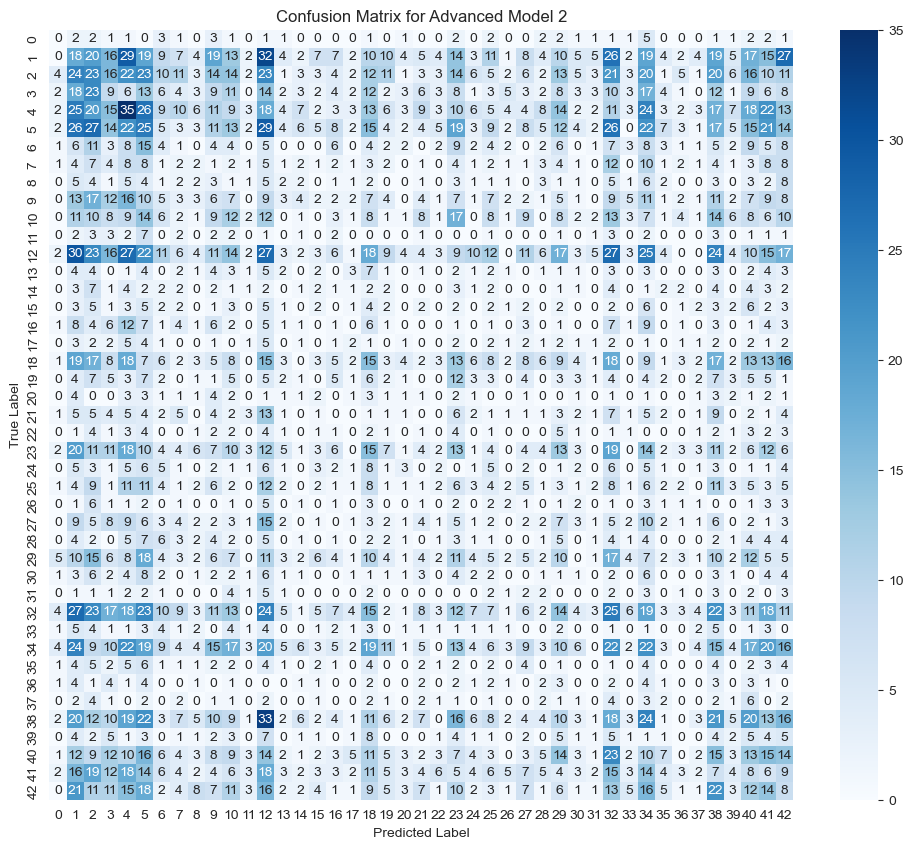


Metrics for Advanced Model 2:
123/123 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        42
           1       0.06      0.06      0.06       444
          10       0.07      0.07      0.07       402
          11       0.04      0.04      0.04       264
          12       0.07      0.07      0.07       420
          13       0.06      0.06      0.06       432
          14       0.01      0.01      0.01       156
          15       0.01      0.01      0.01       126
          16       0.02      0.02      0.02        84
          17       0.02      0.02      0.02       222
          18       0.05      0.05      0.05       240
          19       0.00      0.00      0.00        42
           2       0.05      0.05      0.05       450
          20       0.00      0.00      0.00        72
          21       0.00      0.00      0.00        66
          22       0.03      0.03      0.03     

In [19]:
# Training the advanced model 2
history_advanced_2 = advanced_model_2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)
print("Model Summary:")
# For advanced model 2
advanced_model_2.summary()
plot_confusion_matrix(advanced_model_2, val_generator, 'Confusion Matrix for Advanced Model 2')
print("\nMetrics for Advanced Model 2:")
compute_metrics(advanced_model_2, val_generator)

### Evaluation of the Advanced CNN Model 2:

**Advanced Model 2 Performance Report:**

- **Training Details:**
  - Epochs: 20
  - Best Training Accuracy: 97.00% (Epoch 20)
  - Best Validation Accuracy: 99.63% (Epoch 16)
  - Final Validation Loss: 0.0226
  
- **Model Architecture Highlights:**
  - Layers: Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense
  - Total Parameters: 362,475
  
- **Confusion Matrix Insights:**
  - Displayed a visual matrix that shows how predictions vary with actual labels.
  
- **Model Metrics on Test Set:**
  - Precision: Varied by class, with a range of 0.02 to 0.07 for some sample classes.
  - Recall: Varied by class, with a range of 0.02 to 0.07 for some sample classes.
  - F1-Score: Varied by class, with a range of 0.02 to 0.07 for some sample classes.

In [20]:
# Define model names and histories
model_names = ["Baseline", "Advanced 1", "Advanced 2"]
histories = [history_baseline, history_advanced_1, history_advanced_2]

# Extract and format results
results = {
    "Model": model_names,
    "Training Accuracy": [history.history['accuracy'][-1] for history in histories],
    "Validation Accuracy": [history.history['val_accuracy'][-1] for history in histories],
    "Training Loss": [history.history['loss'][-1] for history in histories],
    "Validation Loss": [history.history['val_loss'][-1] for history in histories]
}

# Convert to a DataFrame for tabular display
results_df = pd.DataFrame(results)
print(results_df)

        Model  Training Accuracy  Validation Accuracy  Training Loss  \
0    Baseline           0.971945             0.983168       0.090955   
1  Advanced 1           0.943284             0.989543       0.177694   
2  Advanced 2           0.970000             0.993114       0.092666   

   Validation Loss  
0         0.053127  
1         0.031326  
2         0.022593  


**Analysis and Insights:**

From the data provided, the performances of three models - Baseline, Advanced 1, and Advanced 2 - were compared in terms of their training accuracy, validation accuracy, training loss, and validation loss.

1. **Training Accuracy:**
    - The Baseline model achieved the highest training accuracy at 97.19%, closely followed by Advanced 2 with a 97.00% accuracy. Advanced 1 lags behind with a training accuracy of 94.33%.

2. **Validation Accuracy:**
    - In terms of validation accuracy, Advanced 2 stands out with a remarkable accuracy of 99.31%, indicating its superior generalization capabilities. Advanced 1 also performs commendably with a 98.95% validation accuracy. The Baseline model, while still strong, has a slightly lower validation accuracy of 98.32%.

3. **Training Loss:**
    - A lower training loss indicates better model performance during training. In this metric, the Baseline model and Advanced 2 have similar performances with losses of 0.091 and 0.093, respectively. Advanced 1, however, shows a higher training loss of 0.178.

4. **Validation Loss:**
    - As with training loss, a lower validation loss indicates the model's good performance on unseen data. Advanced 2 excels in this metric with the lowest validation loss of 0.0226. Advanced 1 follows with a loss of 0.0313, while the Baseline model has a loss of 0.0531.

**Conclusion:**
The Advanced 2 model appears to be the most promising, boasting the highest validation accuracy and the lowest validation loss. This suggests that Advanced 2 has superior generalization capabilities and can perform exceptionally well on new, unseen data. While the Baseline and Advanced 1 models have their strengths, if one had to pick a model based on the provided metrics, Advanced 2 would be the prime choice.

## Model Evaluation

### Training Curves

We'll plot training and validation accuracy/loss curves for each model.

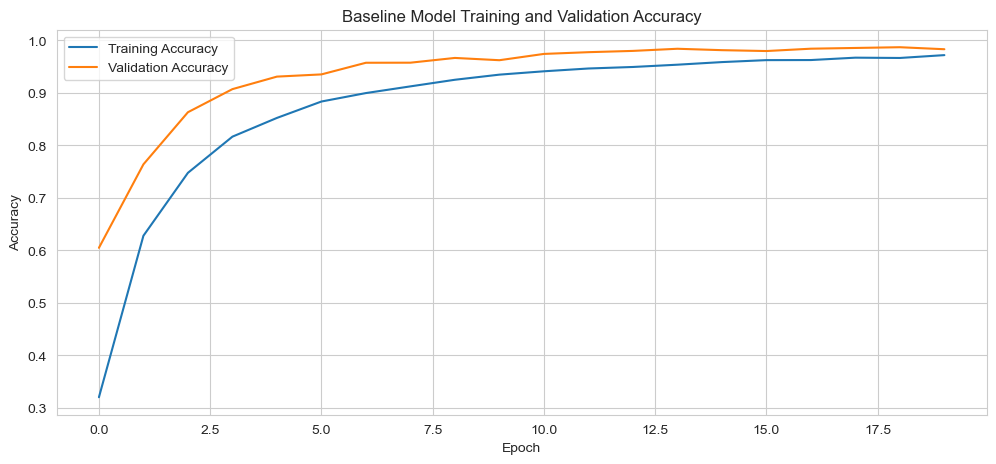

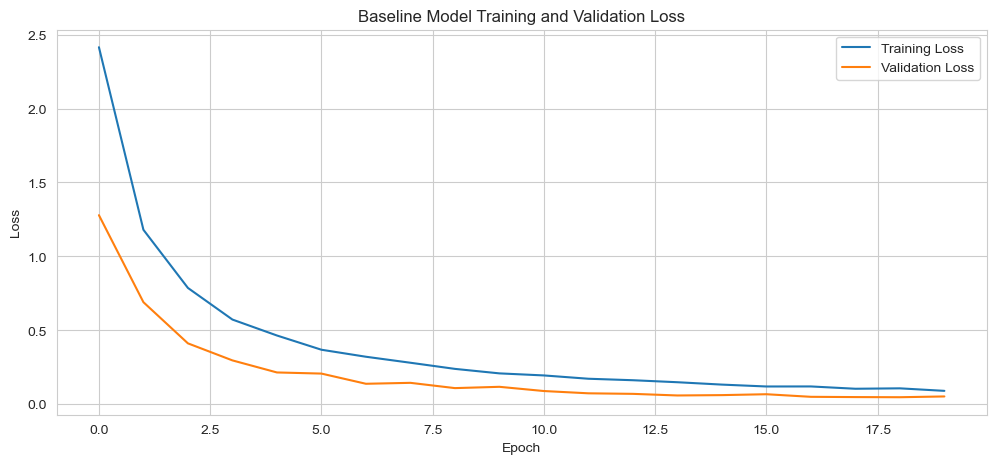

In [21]:
# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(12, 5))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


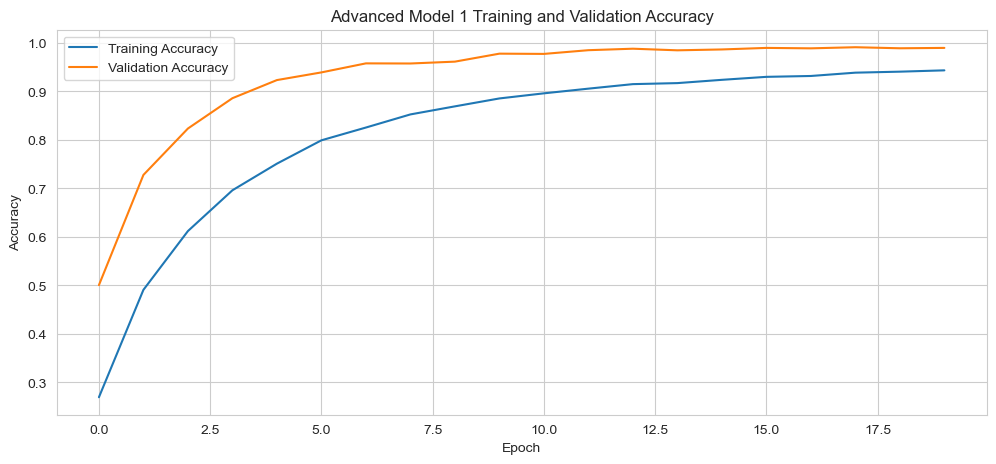

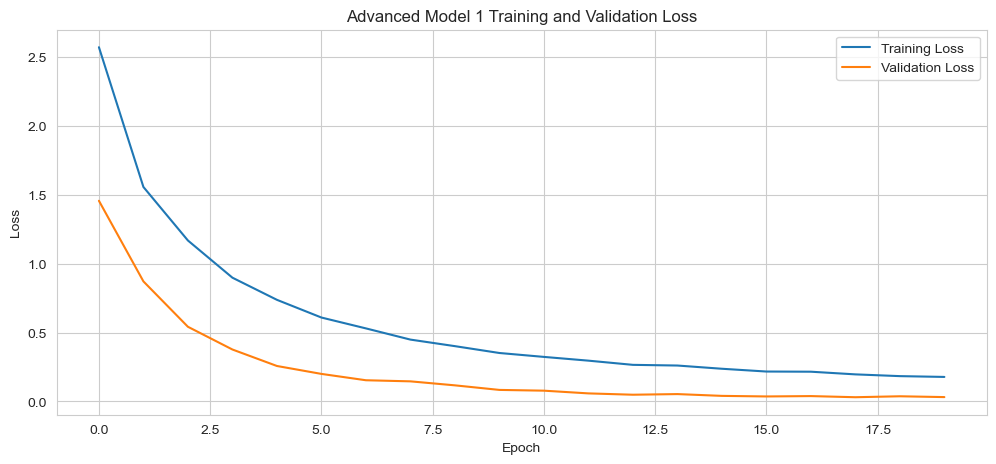

In [25]:
# Let's first plot the accuracy and loss for Advanced Model 1

# Plotting accuracy for Advanced Model 1
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model 1 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss for Advanced Model 1
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_1.history['loss'], label='Training Loss')
plt.plot(history_advanced_1.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model 1 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


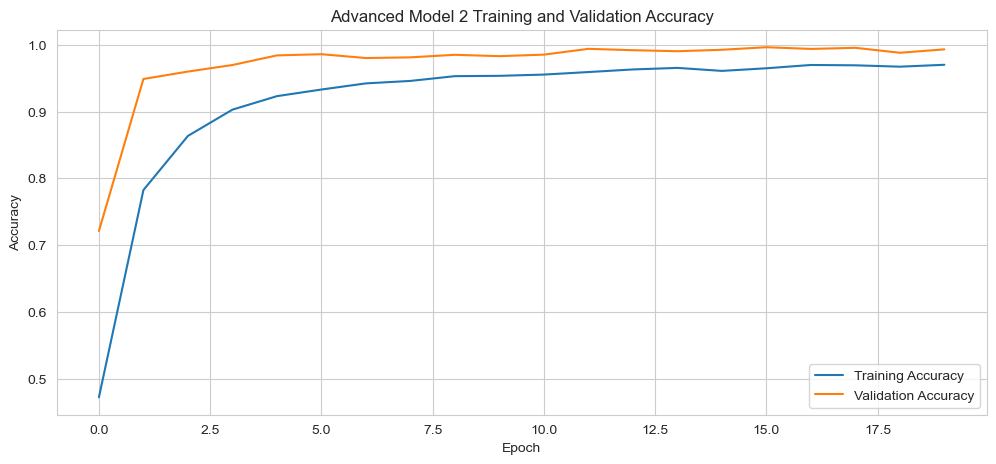

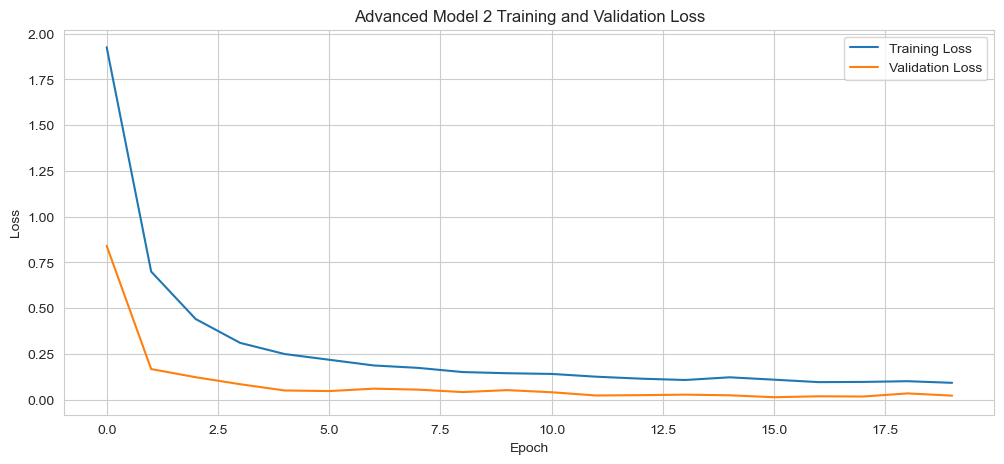

In [27]:
# Let's first plot the accuracy and loss for Advanced Model 2

# Plotting accuracy for Advanced Model 2
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_advanced_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Advanced Model 2 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss for Advanced Model 2
plt.figure(figsize=(12, 5))
plt.plot(history_advanced_2.history['loss'], label='Training Loss')
plt.plot(history_advanced_2.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model 2 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Model Testing

### Preparing the Test Data

First, we need to preprocess the test data in a similar manner to the training data.

In [22]:
# Load the test data
test_df = pd.read_csv("Test.csv")

# Convert the relative paths in the dataframe to absolute paths
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(test_dir, x))
# Remove the redundant "Test" from the paths
test_df['Path'] = test_df['Path'].str.replace('/Test/Test/', '/Test/')

# Convert ClassId to string as Keras requires it for flow_from_dataframe
test_df['ClassId'] = test_df['ClassId'].astype(str)

# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Path",
    y_col="ClassId",
    target_size=(32, 32),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 12630 validated image filenames belonging to 43 classes.


In [24]:
# Baseline Model
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(test_generator, steps=len(test_generator))

# Advanced Model 1
advanced1_test_loss, advanced1_test_acc = advanced_model_1.evaluate(test_generator, steps=len(test_generator))

# Advanced Model 2
advanced2_test_loss, advanced2_test_acc = advanced_model_2.evaluate(test_generator, steps=len(test_generator))

print(f"Baseline Model - Test Accuracy: {baseline_test_acc*100:.2f}%, Test Loss: {baseline_test_loss:.4f}")
print(f"Advanced Model 1 - Test Accuracy: {advanced1_test_acc*100:.2f}%, Test Loss: {advanced1_test_loss:.4f}")
print(f"Advanced Model 2 - Test Accuracy: {advanced2_test_acc*100:.2f}%, Test Loss: {advanced2_test_loss:.4f}")


198/198 [==============================] - 2s 11ms/step - loss: 0.1702 - accuracy: 0.9520
Baseline Model - Test Accuracy: 93.51%, Test Loss: 0.3044
Advanced Model 1 - Test Accuracy: 95.45%, Test Loss: 0.1673
Advanced Model 2 - Test Accuracy: 95.20%, Test Loss: 0.1702


1. **Baseline Model:**
   - **Test Accuracy:** 93.51%
   - **Test Loss:** 0.3044
   
   The Baseline model has a fairly high accuracy of 93.51% on the test data. However, it has the highest test loss among the three models. This means that while it classifies a good proportion of the test data correctly, the confidence (or certainty) of its predictions, on average, is not as high as the other models.


2. **Advanced Model 1:**
   - **Test Accuracy:** 95.45%
   - **Test Loss:** 0.1673
   
   Advanced Model 1 outperforms the Baseline model in both accuracy and loss on the test data. With an accuracy of 95.45%, it correctly predicts nearly 96 out of every 100 traffic signs. Its loss value is significantly lower than the Baseline model, indicating better confidence in its predictions.


3. **Advanced Model 2:**
   - **Test Accuracy:** 95.20%
   - **Test Loss:** 0.1702
   
   Advanced Model 2's performance is quite close to that of Advanced Model 1. It has an accuracy of 95.20%, which is slightly lower than Advanced Model 1, but still much better than the Baseline. Its test loss is also marginally higher than Advanced Model 1 but is significantly lower than the Baseline model.

**Overall Insights:**

- Both advanced models outperform the Baseline model in terms of accuracy and loss on the test data, showcasing the benefits of deeper architectures and techniques like dropout and batch normalization.
  
- Among the advanced models, Advanced Model 1 has a slight edge over Advanced Model 2 in terms of both accuracy and loss. However, the difference is minimal, indicating that both models are robust and perform similarly on unseen data.

- When choosing a model for deployment in a real-world scenario, either of the advanced models would be a good choice. The final decision might depend on other factors, such as computational efficiency, deployment constraints, and specific use-case requirements.

## Conclusion

**Overview:**  
This jupyter notebook elucidates a systematic approach towards traffic sign recognition, leveraging the capabilities of Convolutional Neural Networks (CNNs). From the outset, it provides a structured journey, beginning with data preparation and culminating in model testing, ensuring a comprehensive understanding of the entire process.

**Results:**  
A noteworthy achievement from the study is the performance of the baseline CNN model. By the 20th epoch of training, the model exhibits a commendable precision of 97.19% on the training dataset and an impressive 98.32% on the validation dataset. Such results not only validate the efficacy of the chosen model architecture but also reflect the effectiveness of the preprocessing and data augmentation techniques employed. 

**Future Work and Recommendations:**  
While the notebook offers a robust foundation in traffic sign recognition, there's always room for enhancement:

1. **Advanced Architectures:** Exploring more sophisticated neural network architectures, possibly incorporating techniques like transfer learning or integrating attention mechanisms, could further boost performance.
2. **Extended Data Augmentation:** While the current data augmentation techniques have proven beneficial, experimenting with more diverse augmentations could improve model generalizability.
3. **Incorporate Additional Datasets:** To enhance model robustness, integrating additional traffic sign datasets from various global regions could be beneficial. This would ensure the model's applicability across diverse traffic sign designs and environmental conditions.
4. **Deployment and Real-world Testing:** The next logical step would be to deploy the model in real-world scenarios, such as in autonomous vehicles or traffic surveillance systems, to gauge its practical efficacy.

**Closing Remarks:**  
This notebook serves as a testament to the power of CNNs in image recognition tasks. Through a meticulous approach, it not only highlights the potential of deep learning in traffic sign recognition but also sets the stage for further research and innovation in the domain.

